In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(spark.sparkContext, '0062b6b9-363a-48ea-8273-51b639cd0891', 'p-577ee47309c0be1153ed7c39d05c265f9295d159')
pc = project.project_context


Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200423192344-0000
KERNEL_ID = 2d948075-e36f-4e26-9594-164494de5f5c


In [2]:

import ibmos2spark
# @hidden_cell
credentials = {#credentials removed
    
}

configuration_name = 'os_c63666ea1c9d403e811d4c86742ad623_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('train.csv', 'bostonhousing-donotdelete-pr-f7plktwicr9r0f'), inferSchema= 'true')
#df.take(5)


In [3]:
df_test = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('test.csv', 'bostonhousing-donotdelete-pr-f7plktwicr9r0f'), inferSchema= 'true')
#df_test.take(5)

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
#removed credentials

body = client_c63666ea1c9d403e811d4c86742ad623.get_object(Bucket='bostonhousing-donotdelete-pr-f7plktwicr9r0f',Key='sample_submission.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

sample_sub = pd.read_csv(body)
sample_sub.head(1)


,Id,SalePrice
0,1461,169277.052498


In [4]:
df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: string (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |--

Some problems with the schema, in particular some features which should be numerical has values which are string, this needs to be adjusted.

In [5]:
num_columns_w_wrongdtype = ['LotFrontage', 'MasVnrArea', 'TotalBsmtSF']

for col in num_columns_w_wrongdtype:
    df_test = df_test.withColumn(col, df_test[col].cast('double'))
    df = df.withColumn(col, df[col].cast('double'))

# MSSubClass describes the building class, should not be a numerical feature
cat_cols_w_wrongdtype = ['MSSubClass']
for col in cat_cols_w_wrongdtype:
    df_test = df_test.withColumn(col, df_test[col].cast('string'))
    df = df.withColumn(col, df[col].cast('string'))




In [6]:
df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: string (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: double (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-- 

In [7]:
# Create two separate lists of categorical and numerical features
columns_cat = [item[0] for item in df.dtypes if item[1].startswith('string')]
columns_num = [item[0] for item in df.dtypes if item[1].startswith('int') | item[1].startswith('double')]



print(columns_cat)
print(columns_num)

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', '

In [8]:
df_test = df_test.replace('NA', '0')
df = df.replace('NA', '0')

for col in columns_num:
    if (col == 'SalePrice') | (col == 'Id'):
        continue
    df_test = df_test.withColumn(col, df_test[col].cast('double'))
    df = df.withColumn(col, df[col].cast('double'))

Check if there are missing values in numerical columns

In [9]:
import pyspark.sql.functions as F

def count_missings(spark_df,sort=True):
    df = spark_df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for (c,c_type) in spark_df.dtypes if c_type not in ('timestamp', 'string', 'date')]).toPandas()

    if len(df) == 0:
        print("There are no any missing values!")
        return None

    if sort:
        df = df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)
        return df[(df['count'] > 0)]

    return df


In [10]:
count_missings(df_test, sort=True)


,count
LotFrontage,227
MasVnrArea,15
TotalBsmtSF,1


In [11]:
count_missings(df, sort=True)

,count
LotFrontage,259
MasVnrArea,8


In [12]:
# Fill null values in numerical columns with 0

df_test = df_test.fillna(0, subset=columns_num)
df = df.fillna(0, subset=columns_num)

In [14]:
#Replace the PoolArea feature with a Has Pool feature, there are very few houses with pools in the dataset (only 7 of 1460)
#from pyspark.ml.feature import Binarizer

#df = df.withColumn("PoolArea", df.PoolArea.cast("double"))

#binarizer = Binarizer(threshold=0.0, inputCol='PoolArea', outputCol='Has_Pool')

#df = binarizer.transform(df)

#df = df.drop('PoolArea')

In [34]:
# Find correlation between numerical features and the sale price

from operator import itemgetter

corr_list = []

for column in columns_num:
    corr_val = df.corr('SalePrice', column)
    corr_list.append((column, corr_val))

corr_list = sorted(corr_list, key=itemgetter(1))

print(corr_list)

num_cols = []

# Create list of numerical cols with a correlation above 0.35 with the sale price
for col, val in corr_list:
    if col == 'SalePrice':
        continue
    if val > 0.5:
        num_cols.append(col)

print(num_cols)
    
    

[('KitchenAbvGr', -0.13590737084214102), ('EnclosedPorch', -0.1285779579259566), ('OverallCond', -0.07785589404867796), ('YrSold', -0.02892258516873857), ('LowQualFinSF', -0.02560613000067957), ('Id', -0.021916719443430967), ('MiscVal', -0.021189579640303206), ('BsmtHalfBath', -0.016844154297358943), ('BsmtFinSF2', -0.011378121450215155), ('3SsnPorch', 0.04458366533574838), ('MoSold', 0.0464322452238194), ('PoolArea', 0.09240354949187317), ('ScreenPorch', 0.11144657114291114), ('BedroomAbvGr', 0.1682131543007397), ('LotFrontage', 0.2096239447994837), ('BsmtUnfSF', 0.21447910554696925), ('BsmtFullBath', 0.22712223313149418), ('LotArea', 0.2638433538714051), ('HalfBath', 0.2841076755947826), ('OpenPorchSF', 0.31585622711605504), ('2ndFlrSF', 0.3193338028320674), ('WoodDeckSF', 0.32441344456812926), ('BsmtFinSF1', 0.38641980624215344), ('Fireplaces', 0.46692883675152763), ('MasVnrArea', 0.4726144990045735), ('YearRemodAdd', 0.5071009671113869), ('YearBuilt', 0.522897332879497), ('TotRmsAb

Create a plot over the correlation between the features that are above the correlation threshold

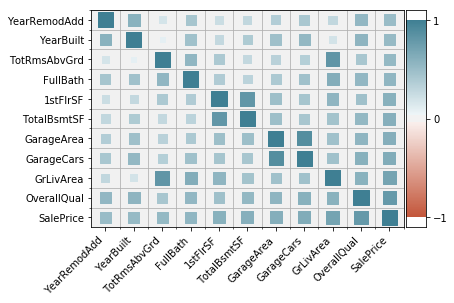

In [35]:
# heatmap is a library using seaborn that makes heatmaps which scales the squares of the heatmap depending on their correlation
from heatmap import corrplot 

num_cols2 = num_cols.copy()
num_cols2.append('SalePrice')

numc_pandas = df.select(num_cols2).toPandas()
corr_numc = numc_pandas.corr()

corrplot(corr_numc, size_scale=230, marker='s')


In [36]:
# Remove column GarageArea, since it's correlation to the sales price is so similar to GarageCars and they both are descriptions of the garage size
num_cols.remove('GarageArea')

print(num_cols)

['YearRemodAdd', 'YearBuilt', 'TotRmsAbvGrd', 'FullBath', '1stFlrSF', 'TotalBsmtSF', 'GarageCars', 'GrLivArea', 'OverallQual']


In [37]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

cat_cols = ['MSZoning', 'HouseStyle', 'CentralAir', 'MSSubClass', 'ExterQual', 'KitchenQual', 'BsmtQual', 'BldgType', 'Neighborhood']

cols_for_model = num_cols + cat_cols + ['SalePrice']

df_red = df[cols_for_model]

stages = []

# Convert categorical strings to index values
for cat_col in cat_cols:
    indexer = StringIndexer(inputCol=cat_col, outputCol= cat_col +'_idx', handleInvalid='keep')
    onehot = OneHotEncoderEstimator(inputCols=[indexer.getOutputCol()], outputCols= [cat_col + '_dummy'])
    stages += [indexer, onehot]

ohecols = [col + '_dummy' for col in cat_cols]
    
# Assemble predictors into a single column 
assembler = VectorAssembler(inputCols=num_cols + ohecols, outputCol='features')

stages += [assembler]

h_train, h_test = df_red.randomSplit([0.8, 0.2], seed=1)

# Print out columns to be used in prediction
print(h_train.columns)


['YearRemodAdd', 'YearBuilt', 'TotRmsAbvGrd', 'FullBath', '1stFlrSF', 'TotalBsmtSF', 'GarageCars', 'GrLivArea', 'OverallQual', 'MSZoning', 'HouseStyle', 'CentralAir', 'MSSubClass', 'ExterQual', 'KitchenQual', 'BsmtQual', 'BldgType', 'Neighborhood', 'SalePrice']


In [38]:
# Create a Gradient boosted tree regressor
gbt = GBTRegressor(featuresCol='features',
                           labelCol='SalePrice',
                           seed=1,
                           stepSize = 0.05,
                           maxIter = 100
                           )


stages += [gbt]


# Create a pipeline
pipeline = Pipeline(stages=stages)

# Create the evaluator, evaluate on Root mean square error
pip_evaluator = RegressionEvaluator(
    labelCol='SalePrice', predictionCol='prediction', metricName='rmse')

# Create a parameter grid to try different parameters
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [5])
             .build())


# Use cross validation to find the best model
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=pip_evaluator, numFolds=5, seed=1)

cvModel = cv.fit(h_train)


In [39]:
# Get the best model from cross validation
best_model = cvModel.bestModel

# Look at the stages in the best model
print(best_model.stages)

# select last stage (the GBTRegressor) of the best model and see info regarding which depth the model has chosen, this can be used on any parameter
print(best_model.stages[-1].explainParam('maxDepth'))

# Generate predictions on testing data using the best model then calculate RMSE
predictions = best_model.transform(h_test)
rmse = pip_evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)



[StringIndexer_4696ac8d40624af00250, OneHotEncoderEstimator_4c4b9aedf93f20d1a441, StringIndexer_4c5d96c4b9df966ce642, OneHotEncoderEstimator_4f508721736b8c40f087, StringIndexer_4b979ba567c631b5ddf7, OneHotEncoderEstimator_4f26a540003e00203043, StringIndexer_47e68d0202f80dad104b, OneHotEncoderEstimator_4717a80c92d5e896ba5c, StringIndexer_470eb59964c32bbec724, OneHotEncoderEstimator_42c1ba1403fb759b3ccf, StringIndexer_4b388d2f126408ed6700, OneHotEncoderEstimator_4b6693558cd2415d78cc, StringIndexer_4d21bc260f1ce83e81d0, OneHotEncoderEstimator_4580a65c2fa826fd7bb7, StringIndexer_4ff696a1fde40b39a157, OneHotEncoderEstimator_45efb7eb36ef9aee96b6, StringIndexer_4d7abb8d5d585d130152, OneHotEncoderEstimator_479a811aa7881e05035b, VectorAssembler_4414a85a24ff88289e77, GBTRegressionModel (uid=GBTRegressor_48ddbbce98cdb932d00f) with 100 trees]
maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 5, current: 5)
Root Mean

Predict the prices for the test set and create a submission file for Kaggle

In [40]:
# Choose the columns
df_test_red = df_test[num_cols + cat_cols]
#df_test = df_test.fillna(0, subset=columns_num)

# Make prediction
kaggle_pred = best_model.transform(df_test)

kaggle_pred = kaggle_pred.withColumn('Id', kaggle_pred['Id'].cast('int'))

# Select only the required columns and convert to pandas dataframe for export
kp_pandas = kaggle_pred.select('prediction', 'Id').toPandas()

kp_pandas['SalePrice'] = kp_pandas.prediction
kp_pandas = kp_pandas.drop(columns=['prediction'])
print(kp_pandas.head())

     Id      SalePrice
0  1461  121278.476449
1  1462  146530.094703
2  1463  155960.090131
3  1464  188645.678523
4  1465  191669.926529


Save the data to a csv-file to be able to submit the results to Kaggle

In [41]:
project.save_data("submission11.csv", kp_pandas.to_csv(index=False))


{'file_name': 'submission11.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'bostonhousing-donotdelete-pr-f7plktwicr9r0f',
 'asset_id': '63882021-c45d-4896-966e-65e768877321'}